In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd

parser = Sbopen()
df, related, freeze, tactics = parser.event(69301)

In [18]:
team_name = "England Women's"

# check index of first sub
sub_index = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == team_name].iloc[0]["index"]

# make df with only succesfull passes before first substitution
mask_passes = (df.type_name == "Pass") & (df.team_name == team_name) & (df.index < sub_index) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")
df_passes = df.loc[mask_passes, ["x", "y", "end_x", "end_y", "player_name", "pass_recipient_name"]]

# adapt player names to only show last name
df_passes["player_name"] = df_passes["player_name"].apply(lambda x: str(x).split()[-1])
df_passes["pass_recipient_name"] = df_passes["pass_recipient_name"].apply(lambda x: str(x).split()[-1])
df_passes.head(20)


,x,y,end_x,end_y,player_name,pass_recipient_name
4,60.0,40.0,61.9,40.9,White,Kirby
8,82.6,37.6,78.4,58.5,Kirby,Bronze
11,84.7,65.3,98.9,77.9,Bronze,Parris
14,94.7,75.5,93.3,64.3,Parris,Scott
63,5.2,8.3,10.8,5.5,Moore,Mead
67,10.1,5.2,5.2,6.2,Mead,Greenwood
74,9.2,12.5,18.8,3.6,Greenwood,Mead
81,24.2,12.2,37.9,65.0,Mead,Bronze
100,13.9,25.5,9.7,20.4,Mead,Kirby
103,86.1,23.7,104.0,12.7,Kirby,Mead


In [41]:
scatter_df = pd.DataFrame()

# create scatter df with entries for each player (name, average location of each pass and recieved pass)
for i, name in enumerate(df_passes["player_name"].unique()):
    # convert a pandas series of all pass coordinates to a numpy array for faster processing
    passx = df_passes.loc[df_passes["player_name"] == name, "x"].to_numpy()
    passy = df_passes.loc[df_passes["player_name"] == name, "y"].to_numpy()
    recx = df_passes.loc[df_passes["pass_recipient_name"] == name, "end_x"].to_numpy()
    recy = df_passes.loc[df_passes["pass_recipient_name"] == name, "end_y"].to_numpy()

    # add a row to the scatter df
    scatter_df.at[i, "player_name"] = name
    # merge the pass and recieving arrays into one and calculate the mean
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    # add the total number of passes made by this player
    scatter_df.at[i, "n_passes"] = df_passes.loc[df_passes["player_name"] == name].count().iloc[0]

# adjust the size of points to clearly show who made more passes
scatter_df["marker_size"] = scatter_df["n_passes"] / scatter_df["n_passes"].max() * 1000

scatter_df

,player_name,x,y,n_passes,marker_size
0,White,82.923529,47.829412,10.0,294.117647
1,Kirby,51.942857,42.457143,26.0,764.705882
2,Bronze,48.093750,69.543750,32.0,941.176471
3,Parris,74.845714,67.257143,15.0,441.176471
4,Moore,58.276000,37.436000,14.0,411.764706
5,Mead,65.075758,15.590909,14.0,411.764706
6,Greenwood,52.773077,11.507692,22.0,647.058824
7,Telford,8.493750,38.568750,12.0,352.941176
8,McManus,36.892187,29.746875,34.0,1000.000000
9,Scott,54.485294,52.285294,16.0,470.588235


In [43]:
# add new column to df_passes with the player pair name: take the two names in a list, sort them alphabetically and join with an underscore
df_passes["player_pair"] = df_passes.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)

# create df frames for passing lines: group the passes df by player pair, count the number of occurrences and only keep one column for the count (x)
lines_df = df_passes.groupby(["player_pair"]).x.count().reset_index()

# set a treshold for the minimum number of passes to be included in the lines df
min_passes = 2
lines_df = lines_df.loc[lines_df["x"] >= min_passes]

lines_df

,player_pair,x
0,Bronze_Houghton,16
1,Bronze_Kirby,9
2,Bronze_McManus,4
4,Bronze_Moore,4
5,Bronze_Parris,16
6,Bronze_Scott,11
7,Bronze_White,3
9,Greenwood_Kirby,6
10,Greenwood_McManus,20
11,Greenwood_Mead,17


Text(0.5, 0.98, "Passing nodes - England Women's")

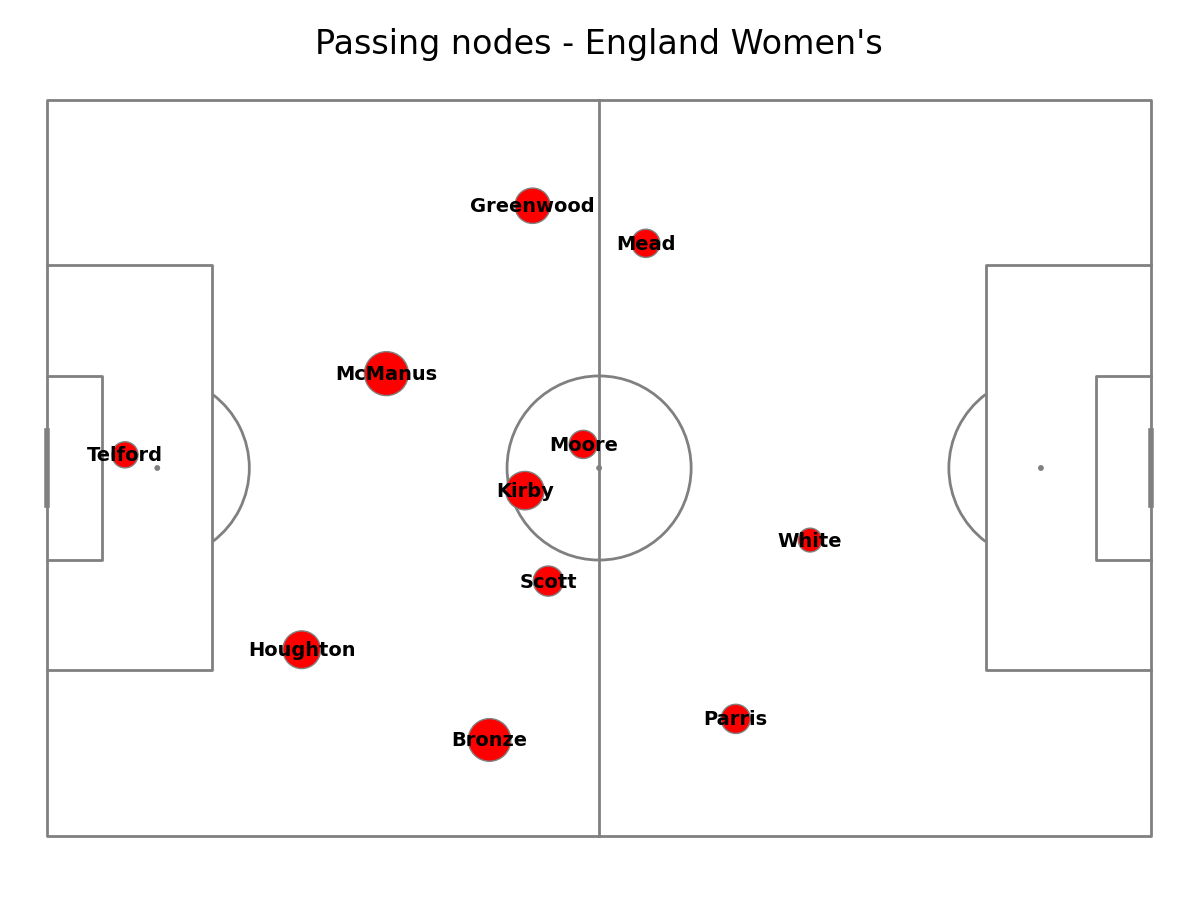

In [49]:
# draw pitch
pitch = Pitch(line_color="grey")
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

# scatter the locations of the players
pitch.scatter(scatter_df["x"], scatter_df["y"], s=scatter_df["marker_size"], ax=ax["pitch"], color="red", edgecolors="grey", linewidth=1, zorder=3)

# annotate the locations with the player name
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c="black", fontsize=14, fontweight="bold", ha="center", va="center", ax=ax["pitch"], zorder=4)

fig.suptitle("Passing nodes - " + team_name, fontsize=24)